In [1]:
import os
import collections
import re
import cv2

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
from pathlib import Path

import sys
sys.path.append("../src")
#importlib.reload(data_conversions)
from conversion_mat_to_py import mat2dict, pretty_dict, matobj2dict, dict2ntuple
from sources_cv2 import defineStartEnd, count_frames
from save_datas import save_data
from data_conversions import acc_to_angle


In [2]:
def SaveStartEnd(new_start_end, name_description):
    
    '''Dados do início e fim do movimento de sentar e levantar'''
    '''Entrada: DataFrame com dados de início e fim da IMU e do frame correspondente'''
    
    caminho = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'
    arquivo = 'Start_End_Sit_and_Stand.csv'
    
    start_end = pd.read_csv(caminho + arquivo, sep = ';')
    
    try:
        start_end.loc[:,[name_description]]
        start_end.loc[:,[name_description]] = new_start_end[[name_description]]
        print('Dados Atualizados')
    except KeyError:
        start_end = pd.merge(start_end, new_start_end, on = 'Description')
        print('Dados Adicionados')
    
    start_end.to_csv(caminho + arquivo, sep = ';', index = False)

In [3]:
# Caminho onde estão os dados .mat
caminho = '/Users/User/OneDrive/TCC/MoVi/IMUmatlab_Subject/'


### -> Escolher o voluntário

In [196]:

# Número do arquivo do voluntário, alterar apenas o número

''' Alterar o número do sujeito analisado'''

voluntary = 24


In [197]:
voluntary = str(voluntary)
imu_filename = caminho + 'imu_Subject_' + voluntary + '.mat'

In [198]:

# Reading MoVi files as a Python dictionary
sample = mat2dict(imu_filename)
pretty_dict(sample, print_type=False, indent=1)

	Key: S1_Synched
		Key: originalFile
		Key: description
		Key: jointNumbers
		Key: jointNames
		Key: dataTypes
		Key: dataTypesDescription
		Key: dataHeader
		Key: data
		Key: delay
		Key: scale
	Key: S2_Synched
		Key: originalFile
		Key: description
		Key: jointNumbers
		Key: jointNames
		Key: dataTypes
		Key: dataTypesDescription
		Key: dataHeader
		Key: data
		Key: delay
		Key: scale
	Key: I1
		Key: originalFile
		Key: description
		Key: jointNumbers
		Key: jointNames
		Key: dataTypes
		Key: dataTypesDescription
		Key: dataHeader
		Key: data
	Key: I2
		Key: originalFile
		Key: description
		Key: jointNumbers
		Key: jointNames
		Key: dataTypes
		Key: dataTypesDescription
		Key: dataHeader
		Key: data
	Key: S1
		Key: originalFile
		Key: description
		Key: jointNumbers
		Key: jointNames
		Key: dataTypes
		Key: dataTypesDescription
		Key: dataHeader
		Key: data
	Key: S2
		Key: originalFile
		Key: description
		Key: jointNumbers
		Key: jointNames
		Key: dataTypes
		Key: dataTypesDescript

# -> Escolher chave!!!

In [199]:

''' Escolher a chave na qual os dados serão utiliados'''
''' S1 possui a pose em pé entre os movimentos'''

key = 'S1_Synched'


In [200]:
Data = sample[key]['data']
name_description = sample[key]['description']
data_complete = pd.DataFrame(Data)

In [201]:
dataHeader_filename = caminho + 'dataHeader.mat'
dataHeader = sio.loadmat(dataHeader_filename)
pretty_dict(dataHeader, print_type=False, indent=1)

header = pd.read_csv(caminho + 'columns.csv', sep=';')
header = header[:].values.tolist()

#Transformar os dados em um data frame para facilitar a visualização
data = pd.DataFrame(Data, columns=header)

	Key: __header__
	Key: __version__
	Key: __globals__
	Key: None
	Key: __function_workspace__


## Separando apenas os dados do movimento de sentar e levantar

Verificar os dados de acordo com os vídeos.



In [202]:
video_path = '/Users/User/OneDrive/TCC/MoVi/Videos/'

if key == 'S1_Synched' or key == 'S1':
    video_S = 'S1'
    
elif key == 'S2_Synched' or key == 'S2':
    video_S = 'S2'

else:
    print('Não possui vídeo correspondente a esses dados')


In [203]:
video_name = video_path + video_S + '_PG1_Subject_' + voluntary + '_L.avi'


# Frequencia dos dados

freq_IMU = 120

n_frames, fps = count_frames(video_name)

# -> Escolher o tempo de início aproximado para o movimento de sentar e levantar

In [204]:
print('Utilizar o vídeo com o seguinte nome: ', video_S + '_PG1_Subject_' + voluntary + '_L.avi' )

Utilizar o vídeo com o seguinte nome:  S1_PG1_Subject_24_L.avi


In [207]:

'''Alterar o tempo de início aproximado do movimento de sentar e levantar'''

# alterar o minuto do vídeo para o movimento de sentar
min_init_video = 1
# alterar o segundo do vídeo para o movimento de sentar
seg_init_video = 22


aprox_init_video = int(((min_init_video * 60) + seg_init_video) * fps)

In [208]:
start_end = defineStartEnd(video_name, n_frames, aprox_init_video)

[2451, 0]
[2451, 2645]


In [209]:
# frame de início e final do movimento de sentar e levantar
frame_start = start_end[0]
frame_end = start_end[1]

# converter o frame do vídeo do início do movimento de sentar para o dado de IMU correspondente 
temp_start = frame_start / fps
IMU_start = int(temp_start * freq_IMU)

# converter o frame do vídeo do final do movimento de levantar para o dado de IMU correspondente 
temp_end = frame_end / fps
IMU_end = int(temp_end * freq_IMU)

# criando os dados apenas com as informações de sentar e levantar
data_sit_to_stand = data.iloc[IMU_start:IMU_end + 1,:]
len(data_sit_to_stand)

777

In [210]:
# Criar DataFrame com os valores das amostras e frames de início e fim
x = [[IMU_start],[IMU_end],[frame_start],[frame_end]]
new_start_end = pd.DataFrame(x, columns = [name_description] )

# Criar DataFrame com os nomes das amostras e frames de início e fim
infos = np.array([['IMU_start'],['IMU_end'],['frame_start'],['frame_end']])
new_start_end_2 = pd.DataFrame(infos, columns = ['Description'])

# Criar DataFrame com os nomes e valores das amotras e frames de início e fim
new_start_end = pd.concat((new_start_end_2, new_start_end), axis = 1)



## Separar apenas os dados de aceleração dos sensores da coxa e os do tronco

Para utilizar os dados de aceleração do pescoço e das pernas, utilizaremos os dados do:
* sensor 1 [10:13], 16 [250:253], 17 [266:269], 18 [282:285], 19 [298:301], 20 [314:317], 21 [330:333] -> quadril, cabeça, pescoço, tronco 3 2 1;
* sensor 2 [26:29] -> coxa direita;
* sensor 5 [74:77] -> coxa esquerda. 



In [211]:
# Criando os dados apenas com os sensores desejados e dados de aceleração
data_set = pd.concat((data_sit_to_stand.iloc[:,10:13], data_sit_to_stand.iloc[:,26:29], data_sit_to_stand.iloc[:,74:77], 
                      data_sit_to_stand.iloc[:,250:253],data_sit_to_stand.iloc[:,266:269], data_sit_to_stand.iloc[:,282:285], 
                      data_sit_to_stand.iloc[:,298:301], data_sit_to_stand.iloc[:,314:317], data_sit_to_stand.iloc[:,330:333]),
                     axis=1)

### Prévia dos dados

In [212]:
data_18_A = data_set.iloc[:,15:18].values
data_5_A = data_set.iloc[:,6:9].values
data_21_A = data_set.iloc[:,24:27].values

In [213]:
angle_rad_neck, angle_neck = acc_to_angle(data_18_A)
angle_rad_right_up_leg, angle_right_up_leg = acc_to_angle(data_5_A)
angle_rad_trunk, angle_trunk = acc_to_angle(data_21_A)

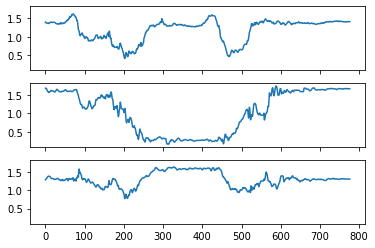

In [214]:
fig, axs = plt.subplots(3, sharex=True, sharey=True)

axs[0].plot(angle_rad_neck)
axs[1].plot(angle_rad_right_up_leg)
axs[2].plot(angle_rad_trunk)

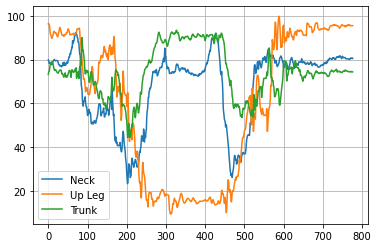

In [215]:
plt.subplot(111)

plt.plot(angle_neck, label = 'Neck')
plt.plot(angle_right_up_leg, label = 'Up Leg')
plt.plot(angle_trunk, label = 'Trunk')

plt.legend()

plt.grid()
plt.show()

### Salvar os dados

In [216]:
# Salvar dados das IMUs referentes ao movimento de sentar e levantar
save_data(data_set, key, name_description)
# Salvar os dados das amostras e frames de início e fim 
SaveStartEnd(new_start_end, name_description)

Dados Adicionados


In [217]:
pd.read_csv('/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'+ name_description +'_Sit_and_Stand.csv', 
            sep = ';')

,01-A-x,01-A-y,01-A-z,02-A-x,02-A-y,02-A-z,05-A-x,05-A-y,05-A-z,16-A-x,...,18-A-z,19-A-x,19-A-y,19-A-z,20-A-x,20-A-y,20-A-z,21-A-x,21-A-y,21-A-z
0,-0.922683,0.072277,0.278539,-1.064538,0.115339,-0.084338,-0.956093,-0.066290,-0.104981,-0.875353,...,0.173477,-0.972714,-0.011349,0.173477,-0.972714,-0.011349,0.173477,-0.922683,0.072277,0.278539
1,-0.951460,0.084014,0.268507,-1.014563,0.126292,-0.053460,-0.962902,-0.052071,-0.108315,-0.869360,...,0.179616,-0.964670,-0.012543,0.179616,-0.964670,-0.012543,0.179616,-0.951460,0.084014,0.268507
2,-0.960570,0.092837,0.266480,-0.967239,0.125958,-0.051177,-0.968135,-0.045529,-0.104622,-0.861738,...,0.197474,-0.959719,-0.007746,0.197474,-0.959719,-0.007746,0.197474,-0.960570,0.092837,0.266480
3,-0.970880,0.092993,0.257869,-0.935837,0.118728,-0.061732,-0.976990,-0.049890,-0.092377,-0.852575,...,0.198945,-0.963504,-0.004233,0.198945,-0.963504,-0.004233,0.198945,-0.970880,0.092993,0.257869
4,-0.993562,0.083962,0.234901,-0.918678,0.114164,-0.078633,-0.982783,-0.061623,-0.061795,-0.850951,...,0.201404,-0.962766,-0.012475,0.201404,-0.962766,-0.012475,0.201404,-0.993562,0.083962,0.234901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,-0.960880,-0.004211,0.269364,-0.984759,0.069803,-0.202941,-0.976600,-0.031288,-0.093836,-0.851988,...,0.163605,-0.984200,-0.054550,0.163605,-0.984200,-0.054550,0.163605,-0.960880,-0.004211,0.269364
773,-0.960976,-0.000081,0.266081,-0.980802,0.073930,-0.206668,-0.976600,-0.034387,-0.093791,-0.851720,...,0.164411,-0.984656,-0.058267,0.164411,-0.984656,-0.058267,0.164411,-0.960976,-0.000081,0.266081
774,-0.960635,-0.003598,0.265264,-0.980414,0.074279,-0.207029,-0.976600,-0.042534,-0.093802,-0.848009,...,0.160540,-0.980791,-0.058623,0.160540,-0.980791,-0.058623,0.160540,-0.960635,-0.003598,0.265264
775,-0.964725,-0.003746,0.269355,-0.980569,0.074129,-0.207165,-0.976600,-0.042981,-0.093800,-0.847666,...,0.159895,-0.980418,-0.058787,0.159895,-0.980418,-0.058787,0.159895,-0.964725,-0.003746,0.269355
